# im2latex

&copy; Copyright 2017 - 2018 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

----
## Predict latex from images

This notebook takes formula images as input and produces the predicted latex as output. It needs the trained model and vocabulary as inputs as well.

-----

In [3]:
import os
import math
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
# pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160

____
### Data setup
Create a new 'predictions_dir' giving it a suitable name - e.g. "predictions" anywhere you'd like. Create another directory under it and copy the image files who's LaTeX you want to generate into it. Set these directory paths below as values of predictions_dir and predictions_image_dir below.


In [5]:
predictions_dir = '~/predictions'
predictions_image_dir = predictions_dir + '/formula_images'


### Set Batch sizes
The overall batch-size - HYPER_batch_size - is set below and it should be a multiple of the intended per-gpu batch_size (which is supplie by the -b option to run.py). HYPER_batch_size = per-gpu-batch-size * num_gpus, which means that when you execute run.py, you need to supply a per-gpu batch-size (using the -b option) = HYPER_batch_size/num_gpus or a factor of it. For e.g. if you had HYPER_batch_size was set to 50 below, and you had 1 GPU, you could supply "-b 50", "-b 25", "-b 10" etc. If you had 2 GPUs, then you can specify "-b 25" and "-b 5" in this case.

If the total number of images to be predicted ends up not being an integral multiple of the batch-size, then we'll duplicate the last one enough number of times to make it so.
So for e.g. if you had 2 GPUs and 998 images to infer, you could duplicate two images (giving them different names) to get a total number of 1000 and then set HYPER_batch_size = 50 and supply "-b 25" option to run.py.

In [6]:
HYPER_batch_size = 50

### Specify Trained Model
Specify the raw-data-dir and of the trained model you want to use for predictions.
Also specify the logdir that you want to pick up the trained model weights (i.e. checkpoint) from.

In [8]:
training_raw_data_dir = '../../data/dataset5/training_56'
training_restore_logdir = '../tb_metrics_view/2017-12-25 21-04-15 PST 140K_noRegroup_score89.09/test_runs/step_00167526_score89.0_publish'

_____

In [9]:
predictions_dir = os.path.expanduser(predictions_dir)
predictions_image_dir = os.path.expanduser(predictions_image_dir)
preds_raw_data_dir = os.path.join(predictions_dir, 'inferencing_%d'%HYPER_batch_size)
preds_logdir = os.path.expanduser(os.path.join(predictions_dir, 'logdir'))
src_dir = os.getcwd()

In [10]:
print('Predictions dir = %s'%predictions_dir)
print('Predicted images are at %s'%predictions_image_dir)

Predictions dir = /home/sumeet/predictions
Predicted images are at /home/sumeet/predictions/formula_images


In [11]:
data_props = pd.read_pickle(os.path.join(training_raw_data_dir, 'data_props.pkl'))
data_props['padded_image_dim']
data_props['word2id']['x']

331

In [12]:
data_dict = {'image':[], 'height':[], 'width':[], 'word2id_len':[], u'bin_len':[], u'word2id':[], u'padded_seq':[], u'padded_seq_len':[], u'seq_len':[], u'squashed_len':[], u'squashed_seq':[]}
df_train_squashed = pd.DataFrame(data_dict)[['image', 'height', 'width', 'word2id_len', u'bin_len', u'word2id', u'padded_seq', u'padded_seq_len', u'seq_len', u'squashed_len', u'squashed_seq']]
df_valid_squashed = pd.DataFrame(data_dict)[['image', 'height', 'width', 'word2id_len', u'bin_len', u'word2id', u'padded_seq', u'padded_seq_len', u'seq_len', u'squashed_len', u'squashed_seq']]

data_props = pd.read_pickle(os.path.join(training_raw_data_dir, 'data_props.pkl'))
max_im_size = data_props['padded_image_dim']

# Set max target sequence length. This is just needed to retrofit the inferencing into the
# training data-frames
l = 300
# Set target sequence to anything. It will be used to generate edit-distance and BLEU score
# in the training cycle, but in the case of inferencing cycle, those values don't mean anything.
# Again, it is needed because the data-frame is supposed to have it for training and validation.
Y = [pd.read_pickle(os.path.join(training_raw_data_dir, 'data_props.pkl'))['word2id']['x']]*l
padded_seq = Y + [0]
padded_len = l + 1
for f in (os.path.basename(p) for p in os.listdir(predictions_image_dir) if os.path.splitext(p)[1] == ".png"):
    im = Image.open(os.path.join(predictions_image_dir,f))
    w = im.size[0]
    h = im.size[1]
    if (w <= max_im_size['width'] and h <= max_im_size['height']):
        data_dict['image'].append(f)
        data_dict['height'].append(h)
        data_dict['width'].append(w)
        data_dict['word2id_len'].append(l)
        data_dict['bin_len'].append(padded_len)
        data_dict['word2id'].append(Y)
        data_dict['padded_seq'].append(padded_seq)
        data_dict['padded_seq_len'].append(padded_len)
        data_dict['seq_len'].append(padded_len)
        data_dict['squashed_len'].append(padded_len)
        data_dict['squashed_seq'].append(padded_seq)
    else:
        print('Discarding image {im} of size {h}x{w}'.format(im=f, h=h, w=w))
df_test_squashed = pd.DataFrame(data_dict)[['image', 'height', 'width', 'word2id_len', u'bin_len', u'word2id', u'padded_seq', u'padded_seq_len', u'seq_len', u'squashed_len', u'squashed_seq']]
print(df_test_squashed.shape)
display(df_test_squashed)

Discarding image 4a2653926b6ffe6_basic.png of size 180x690
Discarding image 707f8aae5ba9b09_basic.png of size 81x1223
(98, 11)


,image,height,width,word2id_len,bin_len,word2id,padded_seq,padded_seq_len,seq_len,squashed_len,squashed_seq
0,aba3c6512b319df_basic.png,82,250,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
1,cabec6bd809d2c6_basic.png,80,313,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
2,0eead2630232cd8_basic.png,34,329,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
3,d774c895a12fa85_basic.png,37,212,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
4,cbac762d2bb3809_basic.png,44,385,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
5,db8fa7896dcc68b_basic.png,42,226,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
6,aad7bc34a7e2afb_basic.png,43,711,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
7,8d6eaaaaf22b990_basic.png,35,496,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
8,f8cce6de370c4f1_basic.png,33,131,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."
9,dabc228be298efd_basic.png,77,515,300,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...","[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ...",301,301,301,"[331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, ..."


In [13]:
if df_test_squashed.shape[0] % HYPER_batch_size > 0:
    shortfall = HYPER_batch_size - (df_test_squashed.shape[0]%HYPER_batch_size)
    print('Duplicating image ' + df_test_squashed.iloc[-1].image + ' ' + str(shortfall) + ' times')
    df_test_squashed = pd.concat([df_test_squashed] + [df_test_squashed.iloc[-1:]]*shortfall)
assert (df_test_squashed.shape[0]%HYPER_batch_size) == 0

Duplicating image 6148adb2718123a_basic.png 2 times


In [14]:
df_test_squashed.shape

(100, 11)

d0749f7cb5418e3_basic.png (662, 73) dpi=None


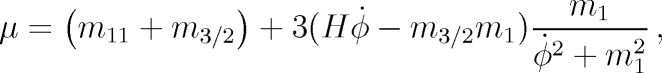

51d344d2d1c1a7f_basic.png (540, 69) dpi=None


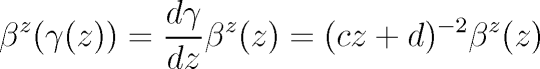

2d17f8da507cc24_basic.png (309, 60) dpi=None


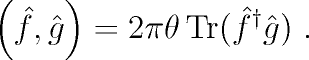

7072219d5304212_basic.png (575, 40) dpi=None


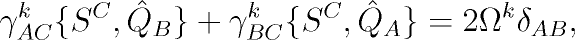

5b3d9d088985673_basic.png (196, 37) dpi=None


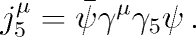

303ff475d415c91_basic.png (868, 42) dpi=None


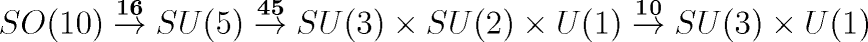

ad9ba07605d9d16_basic.png (976, 100) dpi=None


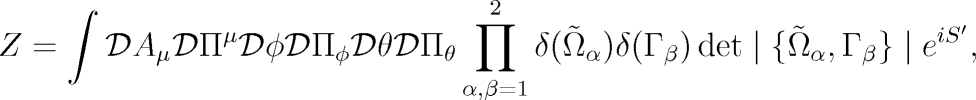

c4289a143328f6f_basic.png (308, 73) dpi=None


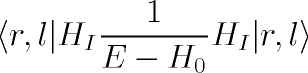

3adbaf322bcd162_basic.png (799, 85) dpi=None


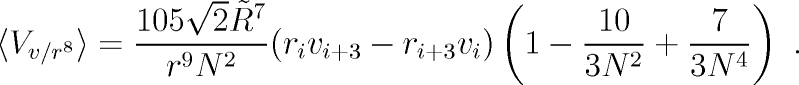

584759206c2b940_basic.png (337, 74) dpi=None


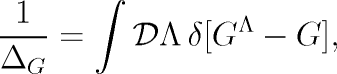

In [15]:
def displayRandImage(df, root):
    filename = df.image.sample(1).values[0]
    path = os.path.join(root, filename);
    image_data = Image.open(path)
    print('{name} {shape} dpi={dpi}'.format(name=filename, shape=image_data.size, 
                                            dpi=image_data.info["dpi"] if 'info' in image_data.info else 'None'))
#     print(path, ' ', image_data.size, image_data.info['dpi'])
    display(ipImage(filename=path, format='png'))
#     print(ipImage)
    return [path, image_data, image_data.size]
image_details = [displayRandImage(df_test_squashed, predictions_image_dir) for _ in range(10)]

In [16]:
def make_seq_bins(df_):
    """
    Creates ndarrays of (padded) sequence bins from df_*_squashed / df_*_padded 
    and pickles them as a dictionary of ndarrays wrapped in dataframes.
    This preprocessing is needed in order to quickly obtain an ndarray of
    token-sequences at training time.
    """
    bin_lens = df_.bin_len.unique()
    bins = {}
    bins_squashed = {}
    
    for len_ in bin_lens:
        df_slice = df_[df_.padded_seq_len == len_]
        bin_ = np.array(df_slice.padded_seq.values.tolist(), dtype=np.int32)
        bin_squashed = np.array(df_slice.squashed_seq.values.tolist(), dtype=np.int32)
        assert bin_.shape[1] == len_
        assert bin_.shape[0] == df_slice.shape[0]
        bins[len_] = pd.DataFrame(bin_, index=df_slice.index)
        bins_squashed[len_] = pd.DataFrame(bin_squashed, index=df_slice.index)
    return bins, bins_squashed

In [17]:
bins_test, bins_sq_test = make_seq_bins(df_test_squashed)
bins_train, bins_sq_train = make_seq_bins(df_train_squashed)
bins_valid, bins_sq_valid = make_seq_bins(df_valid_squashed)

### Persist to Disk
Run the notebook initially with the parameter "dump_to_disk" set to False. Finally, after you're convinced that everything is working, switch the flag "dump_to_disk" to True and rerun the notebook and this time it will write the output to disk.

In [18]:
dump_to_disk = True
if dump_to_disk:
    if not os.path.exists(preds_raw_data_dir):
        os.makedirs(preds_raw_data_dir)
    with open(os.path.join(preds_raw_data_dir, 'batch_size.pkl'), 'wb') as f:
      pickle.dump(HYPER_batch_size, f, pickle.HIGHEST_PROTOCOL)
        
    df_train_squashed.to_pickle(os.path.join(preds_raw_data_dir, 'df_train.pkl'))
    df_test_squashed.to_pickle(os.path.join(preds_raw_data_dir, 'df_test.pkl'))
    df_valid_squashed.to_pickle(os.path.join(preds_raw_data_dir, 'df_valid.pkl'))
    
    for t in [('train', bins_train, bins_sq_train), 
              ('test', bins_test, bins_sq_test), 
              ('valid', bins_valid, bins_sq_valid)]:
        with open(os.path.join(preds_raw_data_dir, 'raw_seq_%s.pkl'%t[0]), 'wb') as f:
          pickle.dump(t[1], f, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(preds_raw_data_dir, 'raw_seq_sq_%s.pkl'%t[0]), 'wb') as f:
          pickle.dump(t[2], f, pickle.HIGHEST_PROTOCOL)

#     with open(os.path.join(preds_raw_data_dir, 'raw_seq_test.pkl'), 'wb') as f:
#       pickle.dump(bins_test, f, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(preds_raw_data_dir, 'raw_seq_sq_test.pkl'), 'wb') as f:
#       pickle.dump(bins_sq_test, f, pickle.HIGHEST_PROTOCOL)

#     with open(os.path.join(preds_raw_data_dir, 'raw_seq_valid.pkl'), 'wb') as f:
#       pickle.dump(bins_valid, f, pickle.HIGHEST_PROTOCOL)
#     with open(os.path.join(preds_raw_data_dir, 'raw_seq_sq_valid.pkl'), 'wb') as f:
#       pickle.dump(bins_sq_valid, f, pickle.HIGHEST_PROTOCOL)
    
    data_props = pd.read_pickle(os.path.join(training_raw_data_dir, 'data_props.pkl'))
#     dict_vocab = pd.read_pickle(os.path.join(training_data_dir, 'step2', 'dict_vocab.pkl'))
#     word2id = dict_vocab['id']
#     id2word = pd.read_pickle(os.path.join(training_data_dir, 'step2', 'dict_id2word.pkl'))
#     data_props['id2word'] = id2word
#     data_props['word2id'] = word2id
#     data_props['K'] = max(id2word.keys()) + 1
#     data_props['SpaceTokenID'] = word2id[' '] if ' ' in word2id else None
#     data_props['NullTokenID'] = word2id[r'\eos']
#     data_props['StartTokenID'] = word2id[r'\bos']
    data_props['MaxSeqLen'] = df_test_squashed.padded_seq_len.max()
#     padded_image_dim = pd.read_pickle(os.path.join(data_dir, 'step3', 'padded_image_dim.pkl'))
#     data_props['padded_image_dim'] = {'height': padded_image_dim['height'], 'width':padded_image_dim['width']}
    with open(os.path.join(preds_raw_data_dir, 'data_props.pkl'), 'wb') as f:
        pickle.dump(data_props, f, pickle.HIGHEST_PROTOCOL)

In [19]:
data_props = pd.read_pickle(os.path.join(preds_raw_data_dir, 'data_props.pkl'))
data_props

{'K': 338,
 'MaxSeqLen': 301,
 'NullTokenID': 0,
 'SpaceTokenID': None,
 'StartTokenID': 1,
 'id2word': {0: '\\eos',
  1: '\\bos',
  2: '!',
  3: '"',
  4: '&',
  5: "'",
  6: '(',
  7: ')',
  8: '*',
  9: '+',
  10: ',',
  11: '-',
  12: '--',
  13: '.',
  14: '/',
  15: '0',
  16: '1',
  17: '2',
  18: '3',
  19: '4',
  20: '5',
  21: '6',
  22: '7',
  23: '8',
  24: '9',
  25: ':',
  26: ';',
  27: '<',
  28: '=',
  29: '>',
  30: 'A',
  31: 'B',
  32: 'C',
  33: 'D',
  34: 'E',
  35: 'F',
  36: 'G',
  37: 'H',
  38: 'I',
  39: 'J',
  40: 'K',
  41: 'L',
  42: 'M',
  43: 'N',
  44: 'O',
  45: 'P',
  46: 'Q',
  47: 'R',
  48: 'S',
  49: 'T',
  50: 'U',
  51: 'V',
  52: 'W',
  53: 'X',
  54: 'Y',
  55: 'Z',
  56: '[',
  57: '\\',
  58: '\\!',
  59: '\\#',
  60: '\\,',
  61: '\\/',
  62: '\\:',
  63: '\\;',
  64: '\\Big',
  65: '\\Bigg',
  66: '\\Biggl',
  67: '\\Biggr',
  68: '\\Bigl',
  69: '\\Bigr',
  70: '\\Delta',
  71: '\\Gamma',
  72: '\\Im',
  73: '\\L',
  74: '\\Lambda',
  75:

In [20]:
import shutil
import glob
from os.path import join as joinpath
shutil.rmtree(preds_logdir, ignore_errors=True)
os.makedirs(preds_logdir)
for f in glob.glob(os.path.join(training_restore_logdir, 'snapshot*')):
    print 'copying ' + os.path.basename(f) + ' to ' + preds_logdir
    shutil.copy2(f, preds_logdir)
print 'copying checkpoints_list to ' + preds_logdir
shutil.copy2(joinpath(training_restore_logdir, 'checkpoints_list'), preds_logdir)

copying snapshot-00167526.data-00000-of-00001 to /home/sumeet/predictions/logdir
copying snapshot-00167526.meta to /home/sumeet/predictions/logdir
copying snapshot-00167526.index to /home/sumeet/predictions/logdir
copying checkpoints_list to /home/sumeet/predictions/logdir


### Running an inferencing cycle
After you've generated the dataset as above and have a trained model snapshot, execute run.py using the --test flag and with --raw-data-folder pointing to the abovementioned directory and providing model snapshot via. the --restore option. The command is printed below for your convenience.

In [21]:
print './run.py -a 0.0001 -e -1 -b 25 -v -1 -i 2 --r-lambda 0.00005 --raw-data-folder {preds_raw_data_dir} --test --save-all-eval --restore {preds_logdir} --image-folder {predictions_image_dir}'\
.format(preds_raw_data_dir=preds_raw_data_dir, preds_logdir=preds_logdir, predictions_image_dir=predictions_image_dir)

./run.py -a 0.0001 -e -1 -b 25 -v -1 -i 2 --r-lambda 0.00005 --raw-data-folder /home/sumeet/predictions/inferencing_50 --test --save-all-eval --restore /home/sumeet/predictions/logdir --image-folder /home/sumeet/predictions/formula_images


#### Come back here after you've run the above command.

### Visualize predictions of predict.ipynb

In [22]:
import sys
sys.path.extend(['../commons'])
import data_commons as dtc
import dl_commons as dlc
import viz_commons as vc
from viz_commons import VisualizeDir, DiffParams, VisualizeStep

/home/sumeet/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
preds_vd = VisualizeDir(os.path.expanduser(predictions_dir + '/logdir/store'))
preds_vs = VisualizeStep(preds_vd, 'test', 167526)
df = preds_vs.strs(key='predicted_ids', trim=True, sortkey='prediction_prob', keys=['image_name', 'prediction_log_prob'], sort_ascending=False, wrap_strs=True)
df = df[['image_name', 'prediction_log_prob', 'prediction_prob', 'predicted_ids']].rename(columns={'predicted_ids':'latex'})
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)
df = df.set_index('image_name')
df

(100, 4)
(100, 4)


,prediction_log_prob,prediction_prob,latex
image_name,,,
814958273049b4b_basic.png,-0.022151,9.780926e-01,$\delta \partial _ { \mu } \phi ( x ) = \partial _ { \mu } \delta \phi ( x ) . $
ede5e22e65825f0_basic.png,-0.023379,9.768927e-01,"$e _ { i } e _ { j } = - \delta _ { i j } + \psi _ { i j } ^ { k } e _ { k } , $"
dba6aef8cb86e1f_basic.png,-0.028282,9.721143e-01,$F _ { \mu \nu } = \pm \tilde { F } _ { \mu \nu } $
50aaa52c3350a68_basic.png,-0.028428,9.719724e-01,$\kappa _ { 1 } ^ { - 2 } = \frac { M ^ { 3 } } { k } \left( 1 - e ^ { - 2 k R } \right) . $
0652219c4126ab7_basic.png,-0.036147,9.644986e-01,"$F ( q , Q ) = - { \frac { i } { 2 } } q ^ { 2 } + q Q . $"
5b3d9d088985673_basic.png,-0.038403,9.623251e-01,"$j _ { 5 } ^ { \mu } = \bar { \psi } \gamma ^ { \mu } \gamma _ { 5 } \psi \, . $"
f8cce6de370c4f1_basic.png,-0.046517,9.545481e-01,"$\partial _ { \phi } = 2 \mathrm { i } \lambda \, . $"
728f514f335f060_basic.png,-0.052506,9.488490e-01,$\omega = 2 \delta \operatorname { l n } \lambda \delta p \; . $
6fd9cd192bbf157_basic.png,-0.075823,9.269800e-01,"$\tilde { u } ^ { 0 } \tilde { a } ^ { 0 } - \tilde { u } ^ { 1 } \tilde { a } ^ { 1 } = 0 , $"


In [24]:
df.to_csv(os.path.expanduser(predictions_dir + '/predictions.csv'))

### Predictions are output to predictions.csv

# END